In [1]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path)

import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import datetime as dt

#force reimport
if 'pygents.aigents_api' in sys.modules:
    del sys.modules['pygents.aigents_api']
if 'pygents.plot' in sys.modules:
    del sys.modules['pygents.plot']
if 'pygents.util' in sys.modules:
    del sys.modules['pygents.util']

from pygents.aigents_api import TextMetrics, load_ngrams, punct, tokenize_re, build_ngrams, Learner
from pygents.plot import plot_dict, plot_dict_bars, matrix_plot, plot_bar_from_list, build_triple_list, build_triple_matrix
from pygents.util import dictcount, contains_seq, agg_min_max_avg_mpe
from pygents.recognition_evaluators import df2labeled, language_metrics, our_evaluator_test, our_evaluator_tm, our_evaluator_top, \
    our_evaluator_true, our_evaluator_false, our_evaluator_random, pre_rec_f1_from_counts, evaluate_tm_df, evaluate_metrics, evaluate_model, \
    full_test_circle, dictval, our_evaluator_top1

grand_t0 = dt.datetime.now()

[nltk_data] Downloading package punkt to /Users/akolonin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from datasets import load_dataset

DS = 'Babakan24'

# dataset: https://huggingface.co/datasets/halilbabacan/combined_synthetic_cognitive_distortions/tree/main
ds = load_dataset(
    "halilbabacan/combined_synthetic_cognitive_distortions",
    split="train",
)

df = ds.to_pandas()
df = df.rename(columns={'text': 'Patient Question', 'label': 'Dominant Distortion'})
df.insert(1, 'Distorted part', value = np.nan)
df.insert(3, 'Secondary Distortion (Optional)', value = np.nan)
# Remove the row with index 738 because it contains a NaN in the text column
df = df.drop(index=738)


mapping = {
    "Labelling":            "Labeling",
    "Mental Filter":        "Mental filter",
    "Should Statements":    "Should statements",
    "All-or-Nothing Thinking": "All-or-nothing thinking"
}

df['Dominant Distortion'] = df['Dominant Distortion'].map(mapping).fillna(df['Dominant Distortion'])

df

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,John walked past me without saying a word He m...,NaN,Mind Reading,NaN
1,"During the meeting, Sarah didn't look at me on...",NaN,Mind Reading,NaN
2,Mike didn't respond to my text right away He m...,NaN,Mind Reading,NaN
3,Jessica didn't smile when she saw me She must ...,NaN,Mind Reading,NaN
4,Tom didn't invite me to his party He must not ...,NaN,Mind Reading,NaN
...,...,...,...,...
4526,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
4527,Now I am at university my peers around me all ...,NaN,Overgeneralization,NaN
4528,He claims he’s severely depressed and has outb...,NaN,Mental filter,NaN
4529,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


# Grid search
### Perform a grid search over all hyper-parameters to determine the best combination for building the model

In [14]:
test_babacan_multiclass_path = './temp/test/'
inclusion_thresholds = [0,10,20,30,40,50,60,70,80,90]
detection_thresholds = [10,20,30,40,50,60,70,80,90]
#selection_metrics = ['F','UF','FN','TF-IDF','UFN','UFN/D/D','FN*UFN','FN*UFN/D','NLMI','FCR','CFR','MR']
selection_metrics = ['F','UF','FN','UFN','TF-IDF','FCR','CFR','MR','NLMI']
n_max_values = [1,2,3,4,5]
splits = [0,1,2]


In [3]:
results = []
for shift in splits:
    accumulator = []
    for n_max in n_max_values:
        full_test_circle(df,test_babacan_multiclass_path,f'multi-df-babacan-split-5-{shift+1}',
                validation_fraction=5,inclusion_thresholds=inclusion_thresholds,
                detection_thresholds=detection_thresholds,n_max=n_max, selection_metrics = selection_metrics,
                all_scores=False,averages=False,split_shift=shift,evaluator=our_evaluator_top,accumulator=accumulator)
    results.append(accumulator)


Shift=0: train=3623, test=907
Labels count: defaultdict(<class 'int'>, {'Mind_Reading': 349, 'Overgeneralization': 353, 'Magnification': 322, 'Labeling': 283, 'Personalization': 283, 'Fortune-telling': 268, 'Emotional_Reasoning': 272, 'Mental_filter': 257, 'Should_statements': 248, 'All-or-nothing_thinking': 236, 'No_Distortion': 752})
Shift=0: train=3623, test=907
Labels count: defaultdict(<class 'int'>, {'Mind_Reading': 349, 'Overgeneralization': 353, 'Magnification': 322, 'Labeling': 283, 'Personalization': 283, 'Fortune-telling': 268, 'Emotional_Reasoning': 272, 'Mental_filter': 257, 'Should_statements': 248, 'All-or-nothing_thinking': 236, 'No_Distortion': 752})
Shift=0: train=3623, test=907
Labels count: defaultdict(<class 'int'>, {'Mind_Reading': 349, 'Overgeneralization': 353, 'Magnification': 322, 'Labeling': 283, 'Personalization': 283, 'Fortune-telling': 268, 'Emotional_Reasoning': 272, 'Mental_filter': 257, 'Should_statements': 248, 'All-or-nothing_thinking': 236, 'No_Disto

In [4]:
summary = []
for l1,l2,l3 in zip(results[0],results[1],results[2]):
    summary.append( l1[0:4] + agg_min_max_avg_mpe((l1[4],l2[4],l3[4])))
summary = sorted(summary, key=lambda x: (-x[6],x[2],x[0],-x[1],x[3])) # sort by -F1avg, SM, NM, -IT, RT
NM, IT, SM, DT = summary[0][:4] 
print(NM, IT, SM, DT)
print()
print([s for s in summary if s[2]=='FCR'][:1])
print([s for s in summary if s[2]=='FN'][:1])
print([s for s in summary if s[2]=='MR'][:1])
print()
for s in summary[:20]:
    print(s)

2 90 MR 40

[(3, 80, 'FCR', 70, 0.8108891184118457, 0.8151585522181606, 0.8132525875906113, 0.19374621651620794)]
[(3, 80, 'FN', 70, 0.8120608355835628, 0.8151585522181606, 0.8134053074497531, 0.14369587152924176)]
[(2, 90, 'MR', 40, 0.8610742344075677, 0.9080631911872221, 0.888908346726792, 2.0875127281470047)]

(2, 90, 'MR', 40, 0.8610742344075677, 0.9080631911872221, 0.888908346726792, 2.0875127281470047)
(3, 90, 'MR', 40, 0.8610742344075677, 0.9080631911872221, 0.888908346726792, 2.0875127281470047)
(4, 90, 'MR', 40, 0.8610742344075677, 0.9080631911872221, 0.888908346726792, 2.0875127281470047)
(5, 90, 'MR', 40, 0.8610742344075677, 0.9080631911872221, 0.888908346726792, 2.0875127281470047)
(2, 90, 'NLMI', 40, 0.8610742344075677, 0.9080631911872221, 0.888908346726792, 2.0875127281470047)
(3, 90, 'NLMI', 40, 0.8610742344075677, 0.9080631911872221, 0.888908346726792, 2.0875127281470047)
(4, 90, 'NLMI', 40, 0.8610742344075677, 0.9080631911872221, 0.888908346726792, 2.0875127281470047)


Shift=0: train=3623, test=907
Labels count: defaultdict(<class 'int'>, {'Mind_Reading': 349, 'Overgeneralization': 353, 'Magnification': 322, 'Labeling': 283, 'Personalization': 283, 'Fortune-telling': 268, 'Emotional_Reasoning': 272, 'Mental_filter': 257, 'Should_statements': 248, 'All-or-nothing_thinking': 236, 'No_Distortion': 752})


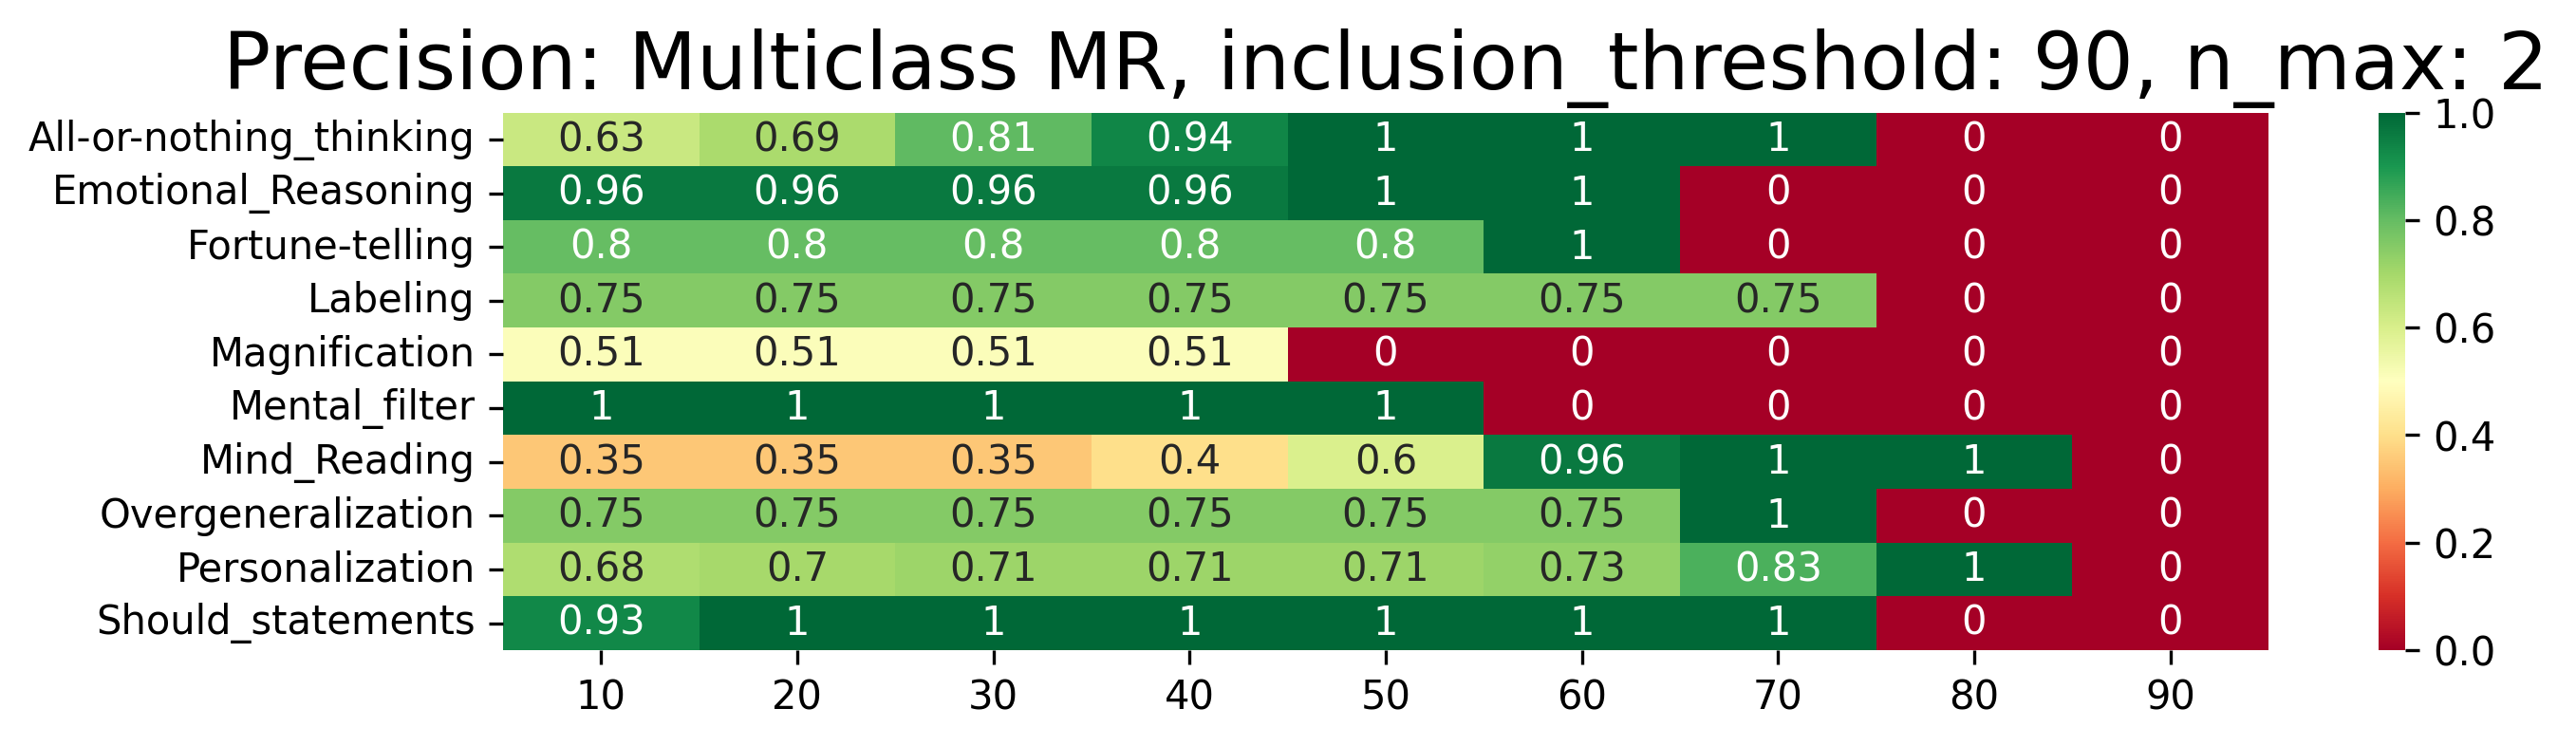

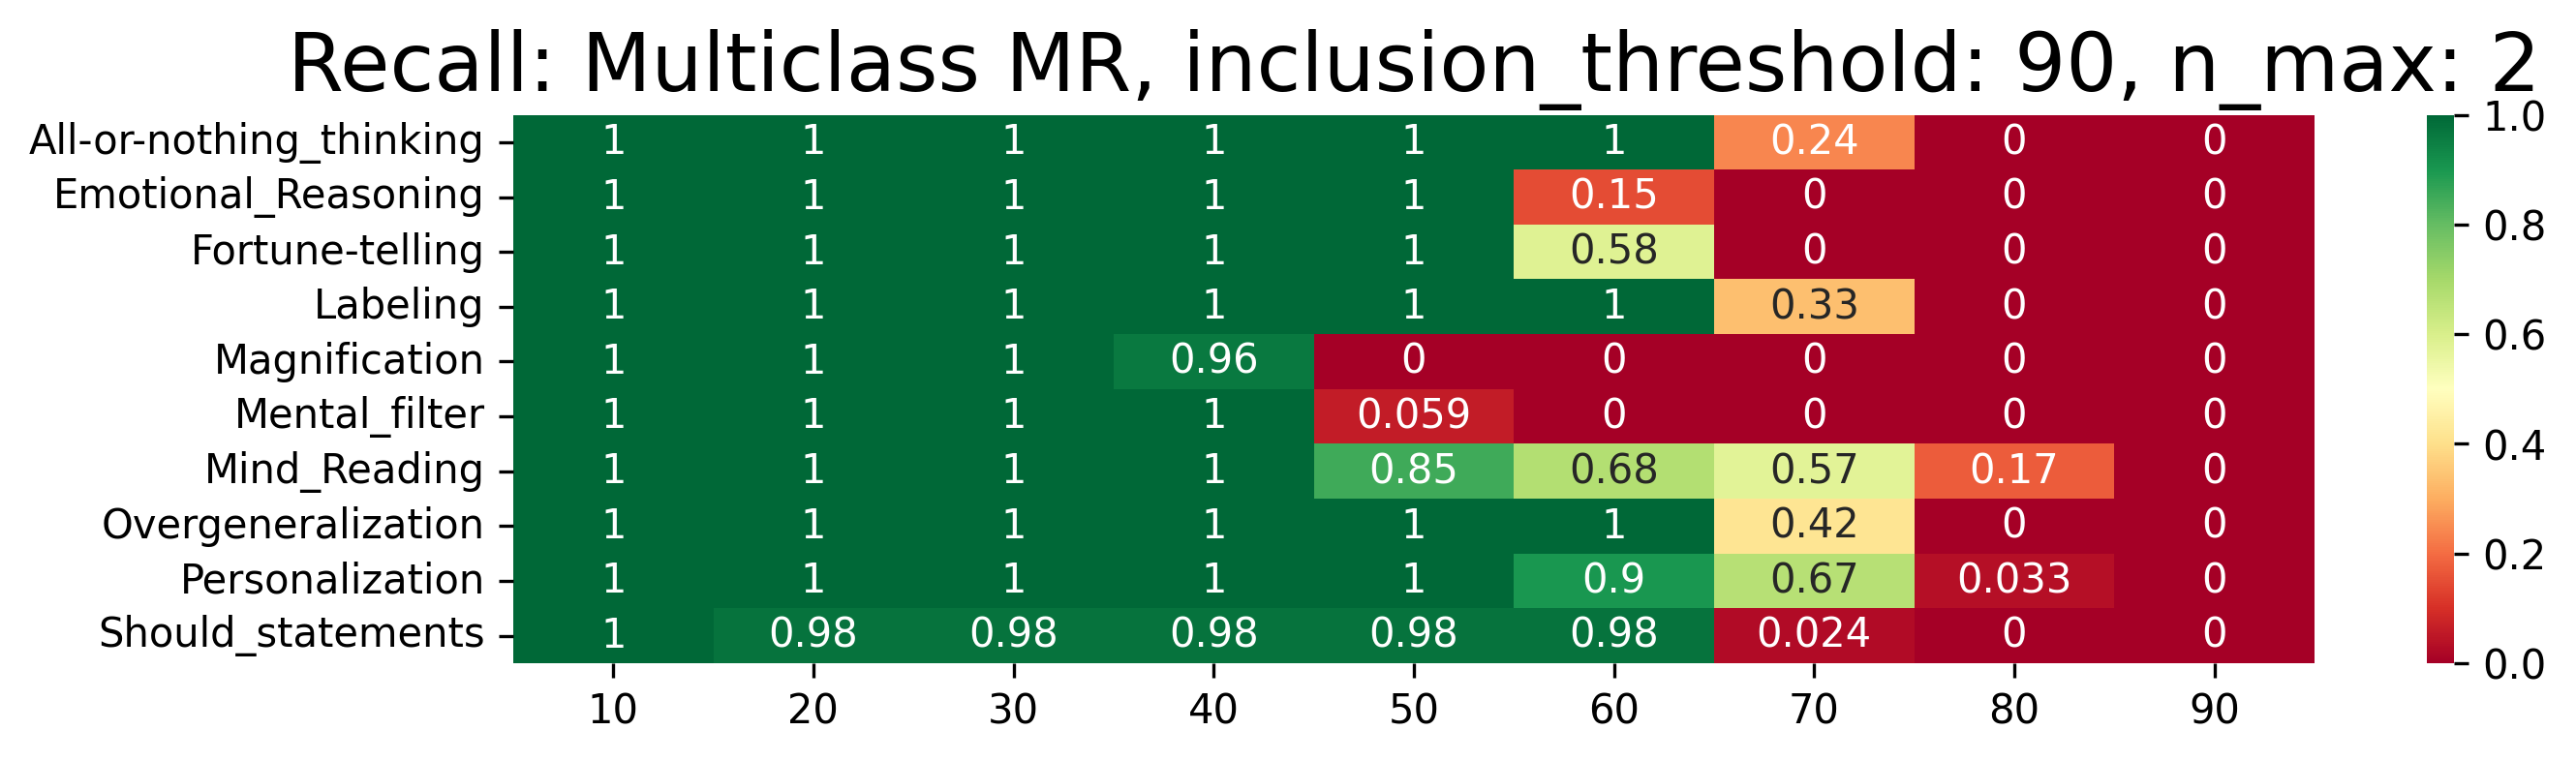

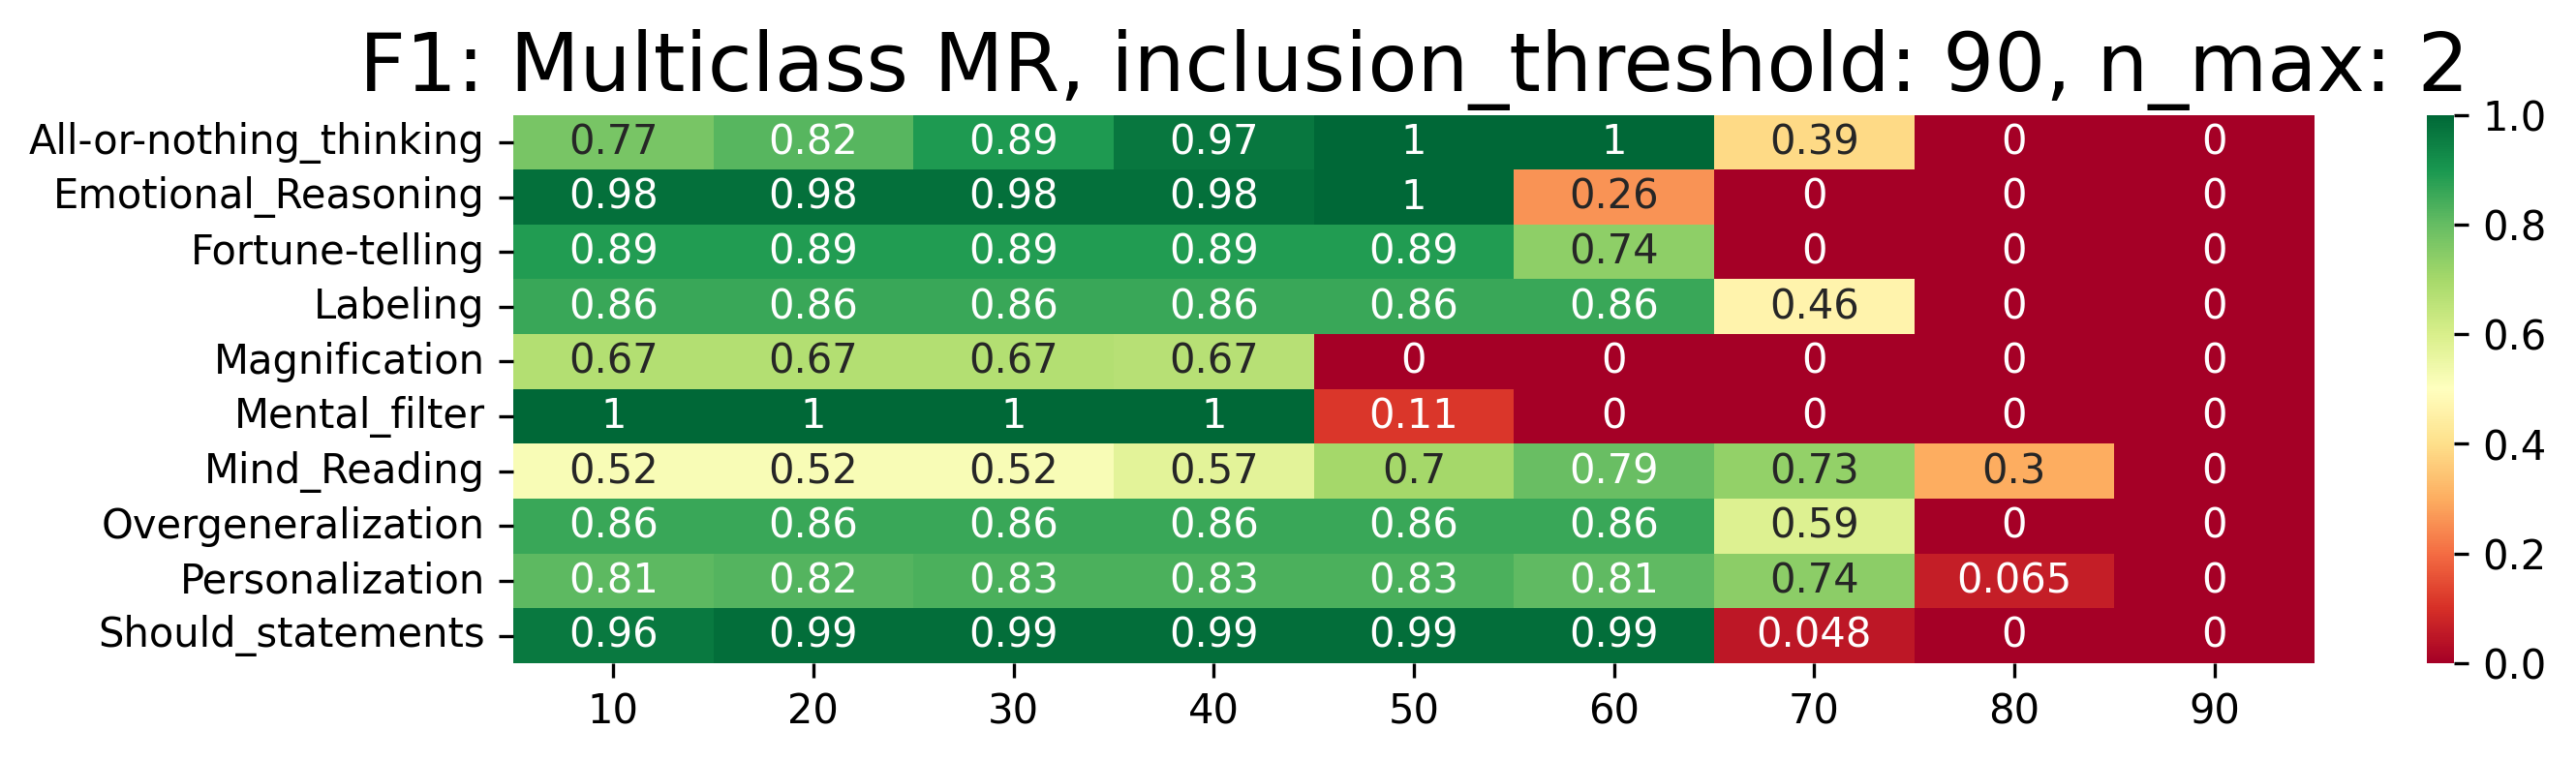

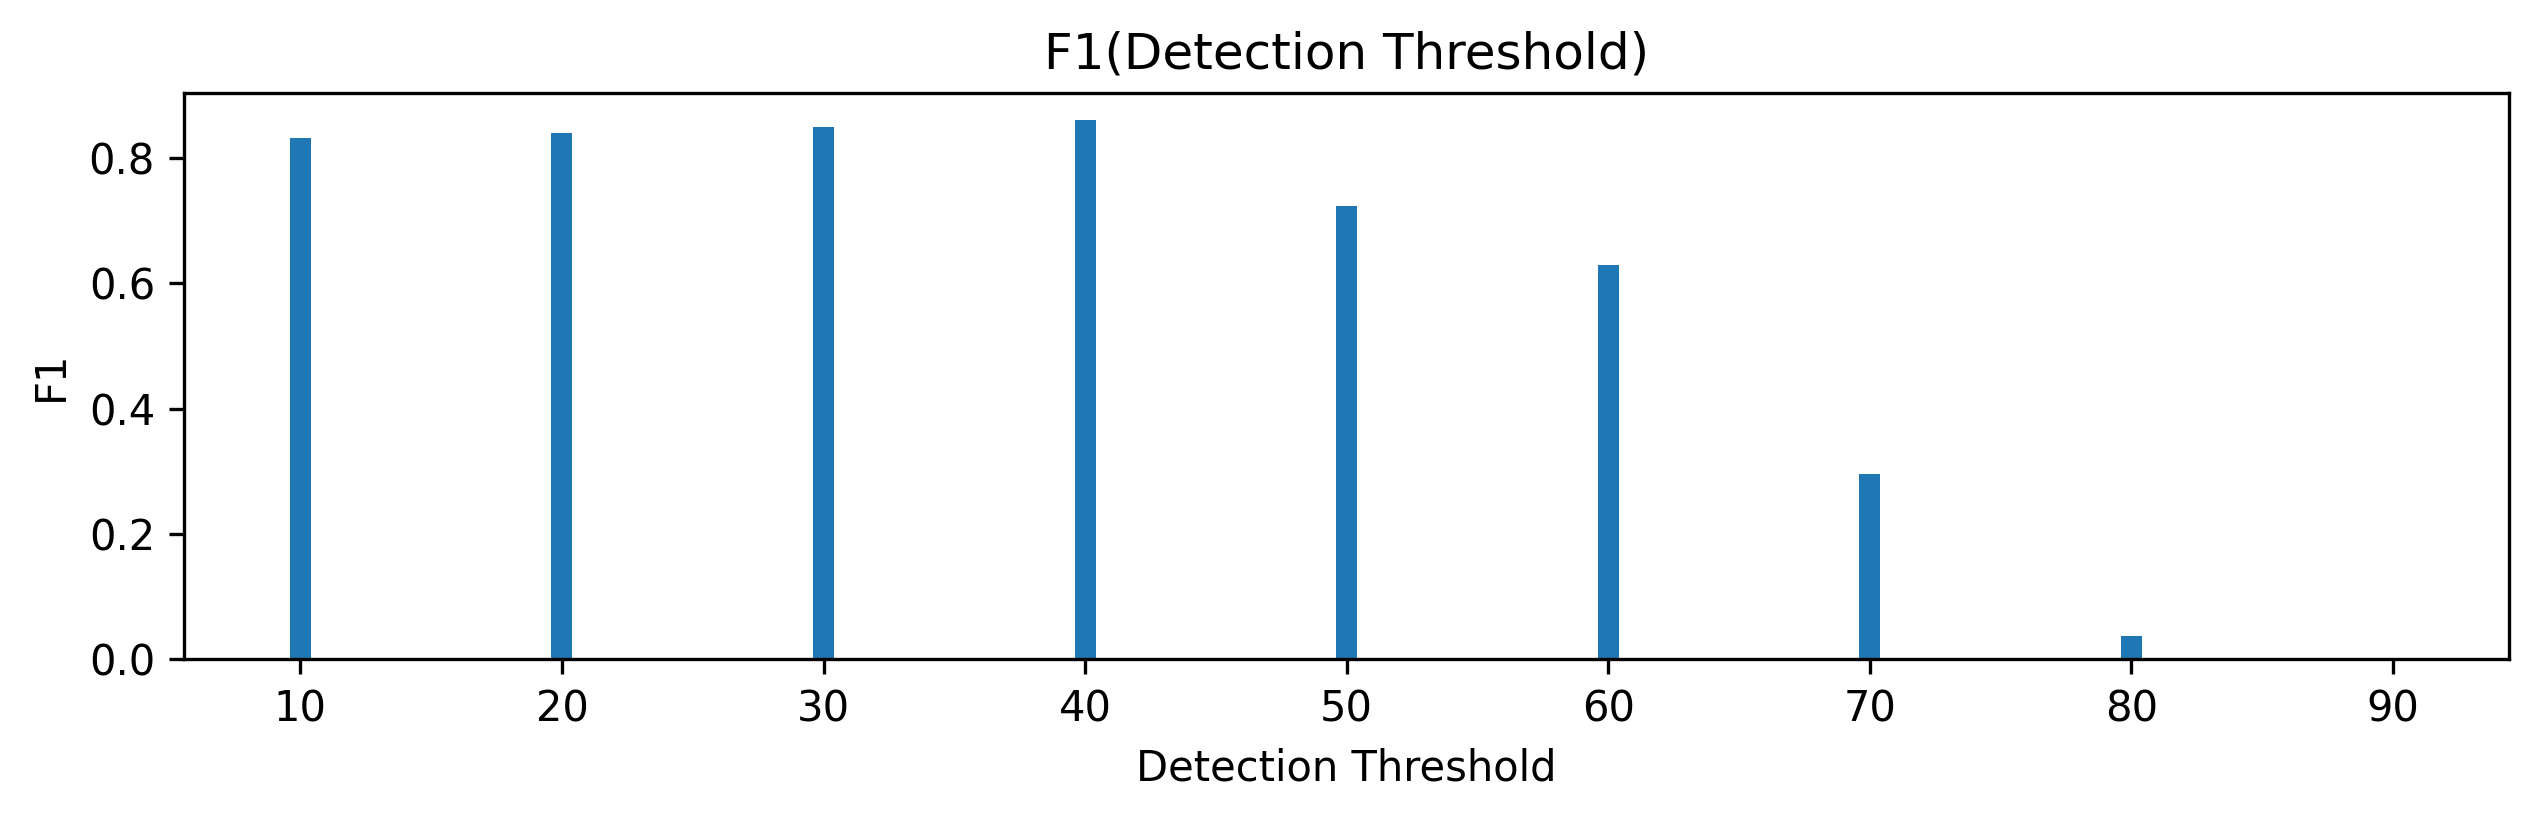

In [5]:
shift = 0
full_test_circle(df,test_babacan_multiclass_path,f'multi-df-babacan-split-5-{shift+1}',
                validation_fraction=5,inclusion_thresholds=[IT],
                detection_thresholds=detection_thresholds,n_max=NM, selection_metrics = [SM],
                all_scores=True,averages=True,split_shift=shift,evaluator=our_evaluator_top)

Shift=0: train=3623, test=907
Labels count: defaultdict(<class 'int'>, {'Mind_Reading': 349, 'Overgeneralization': 353, 'Magnification': 322, 'Labeling': 283, 'Personalization': 283, 'Fortune-telling': 268, 'Emotional_Reasoning': 272, 'Mental_filter': 257, 'Should_statements': 248, 'All-or-nothing_thinking': 236, 'No_Distortion': 752})


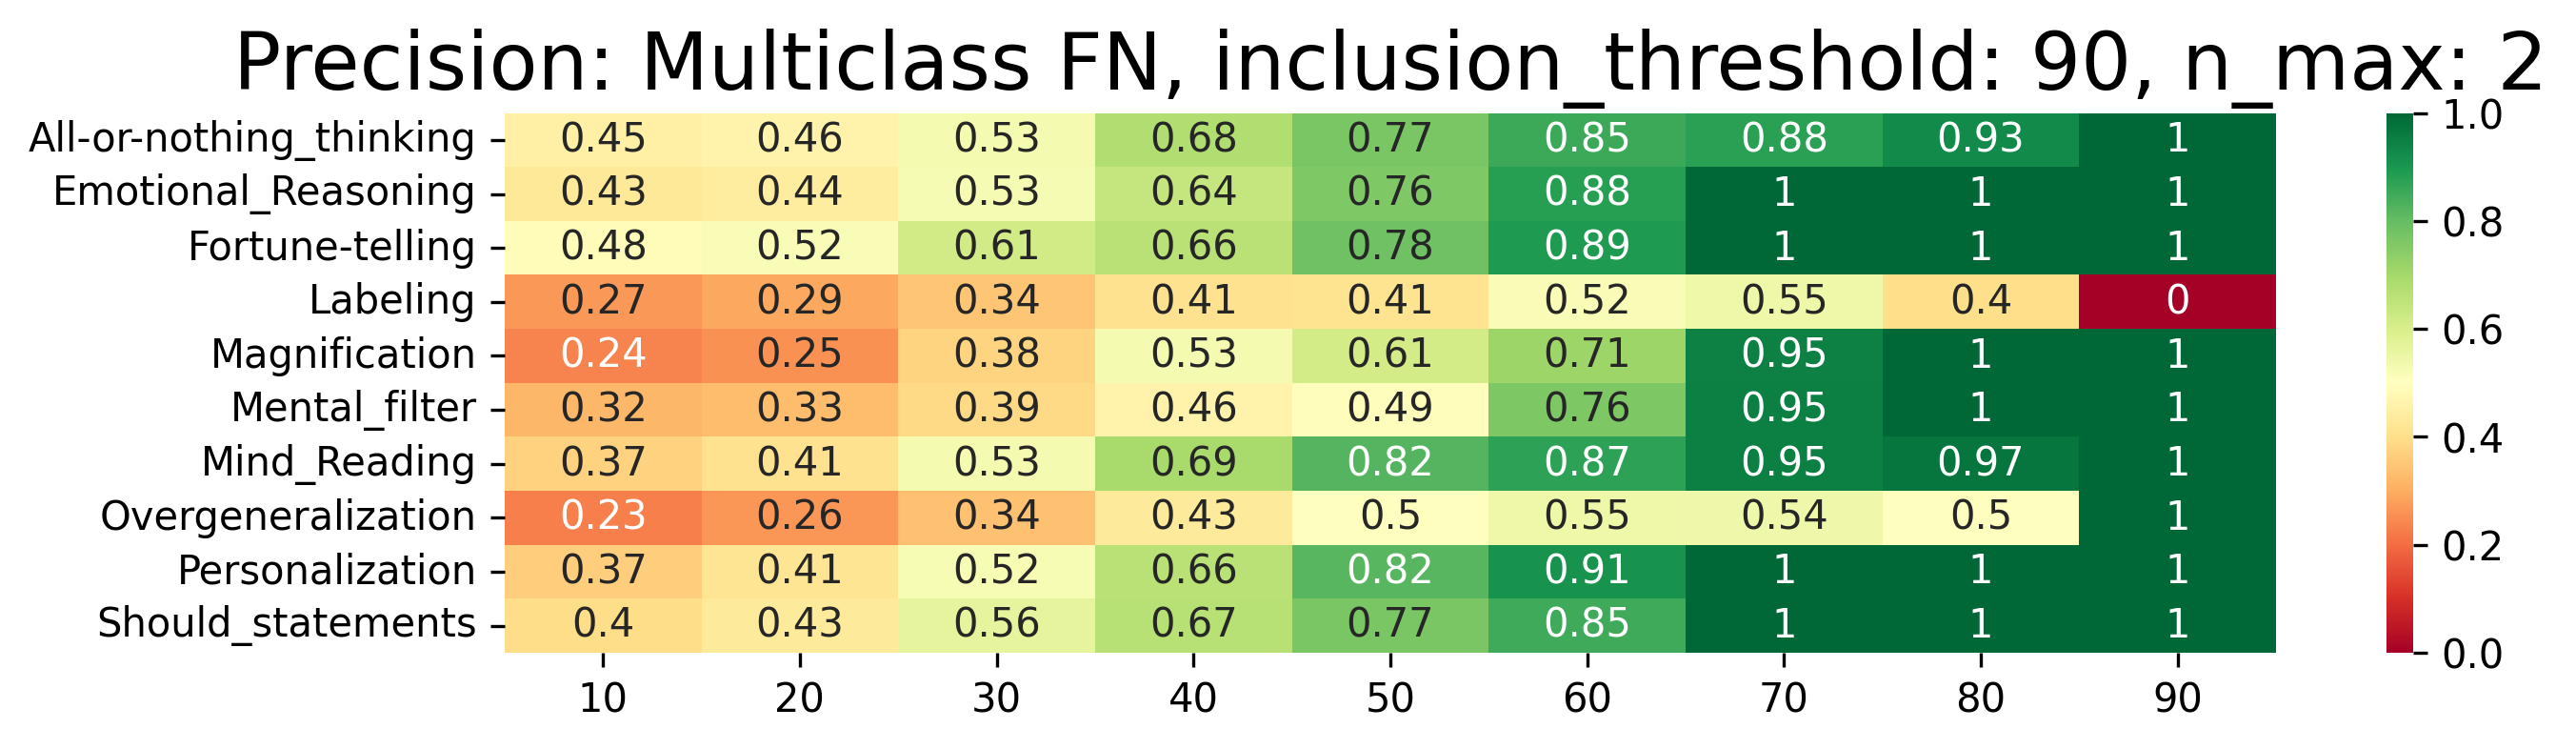

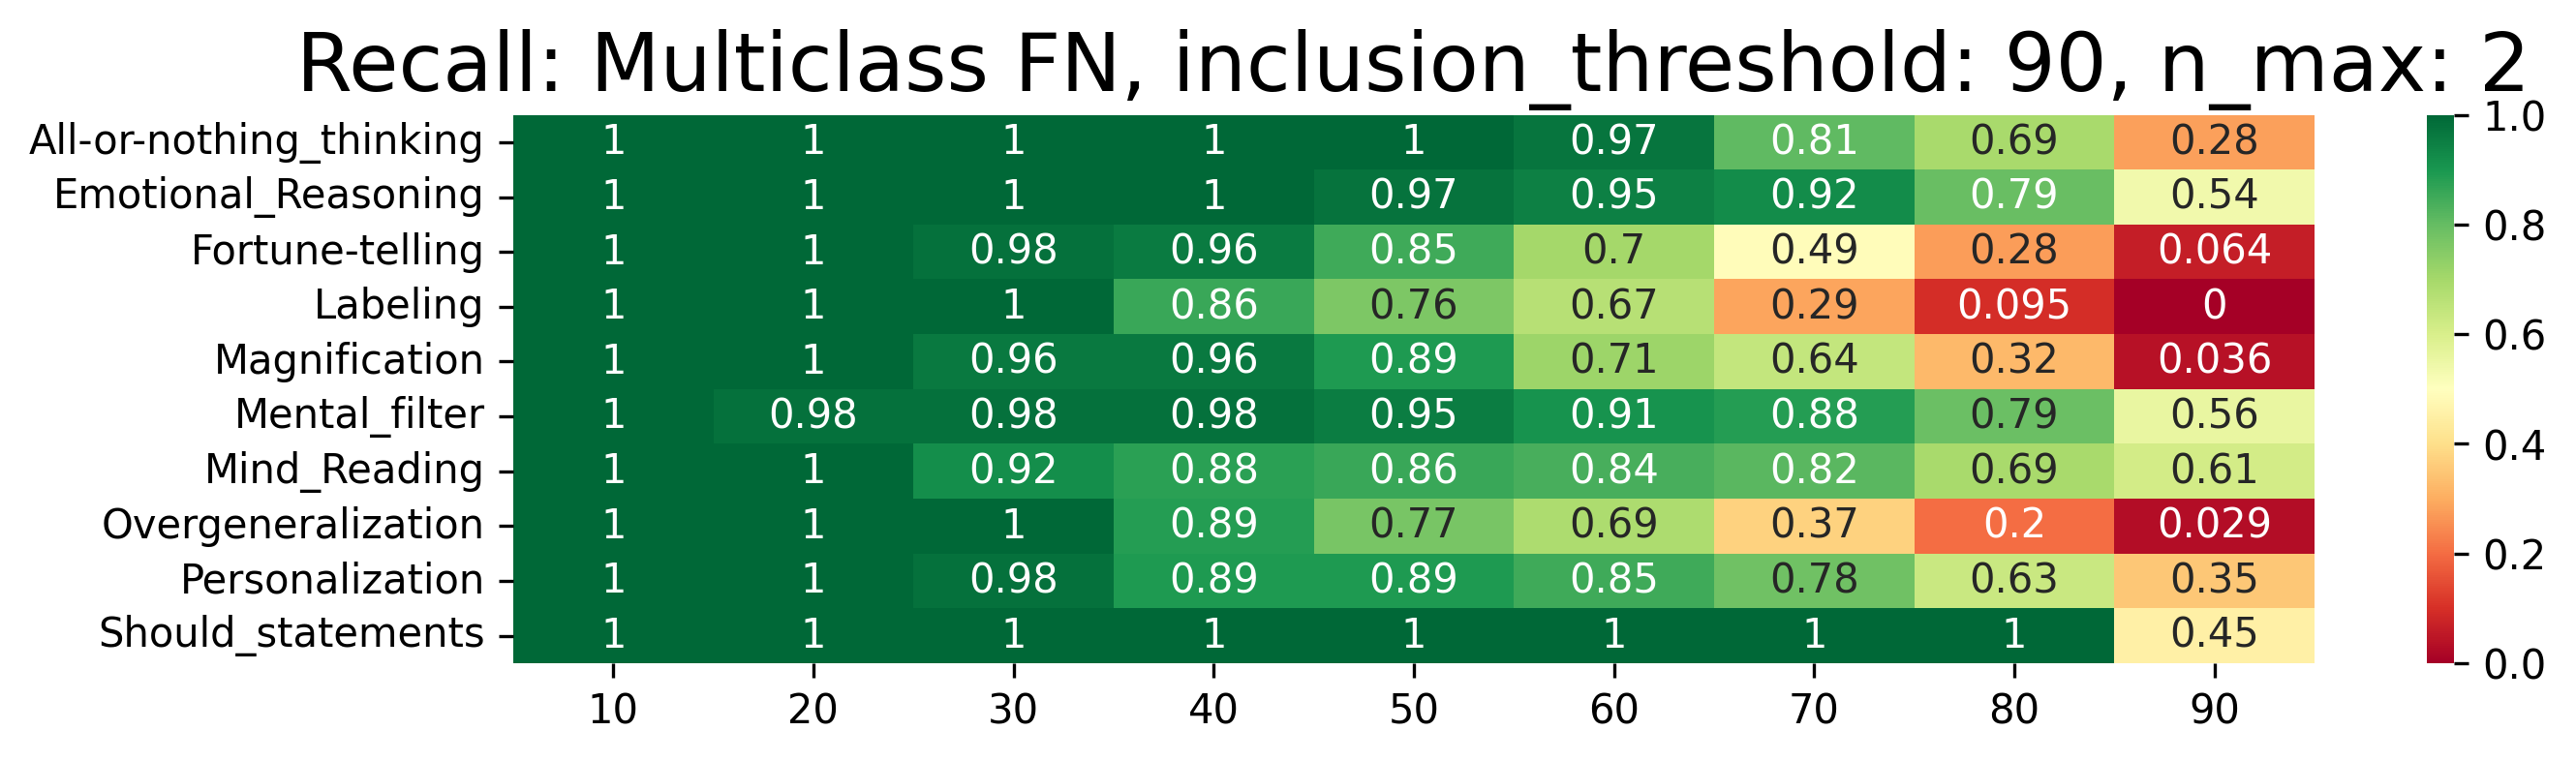

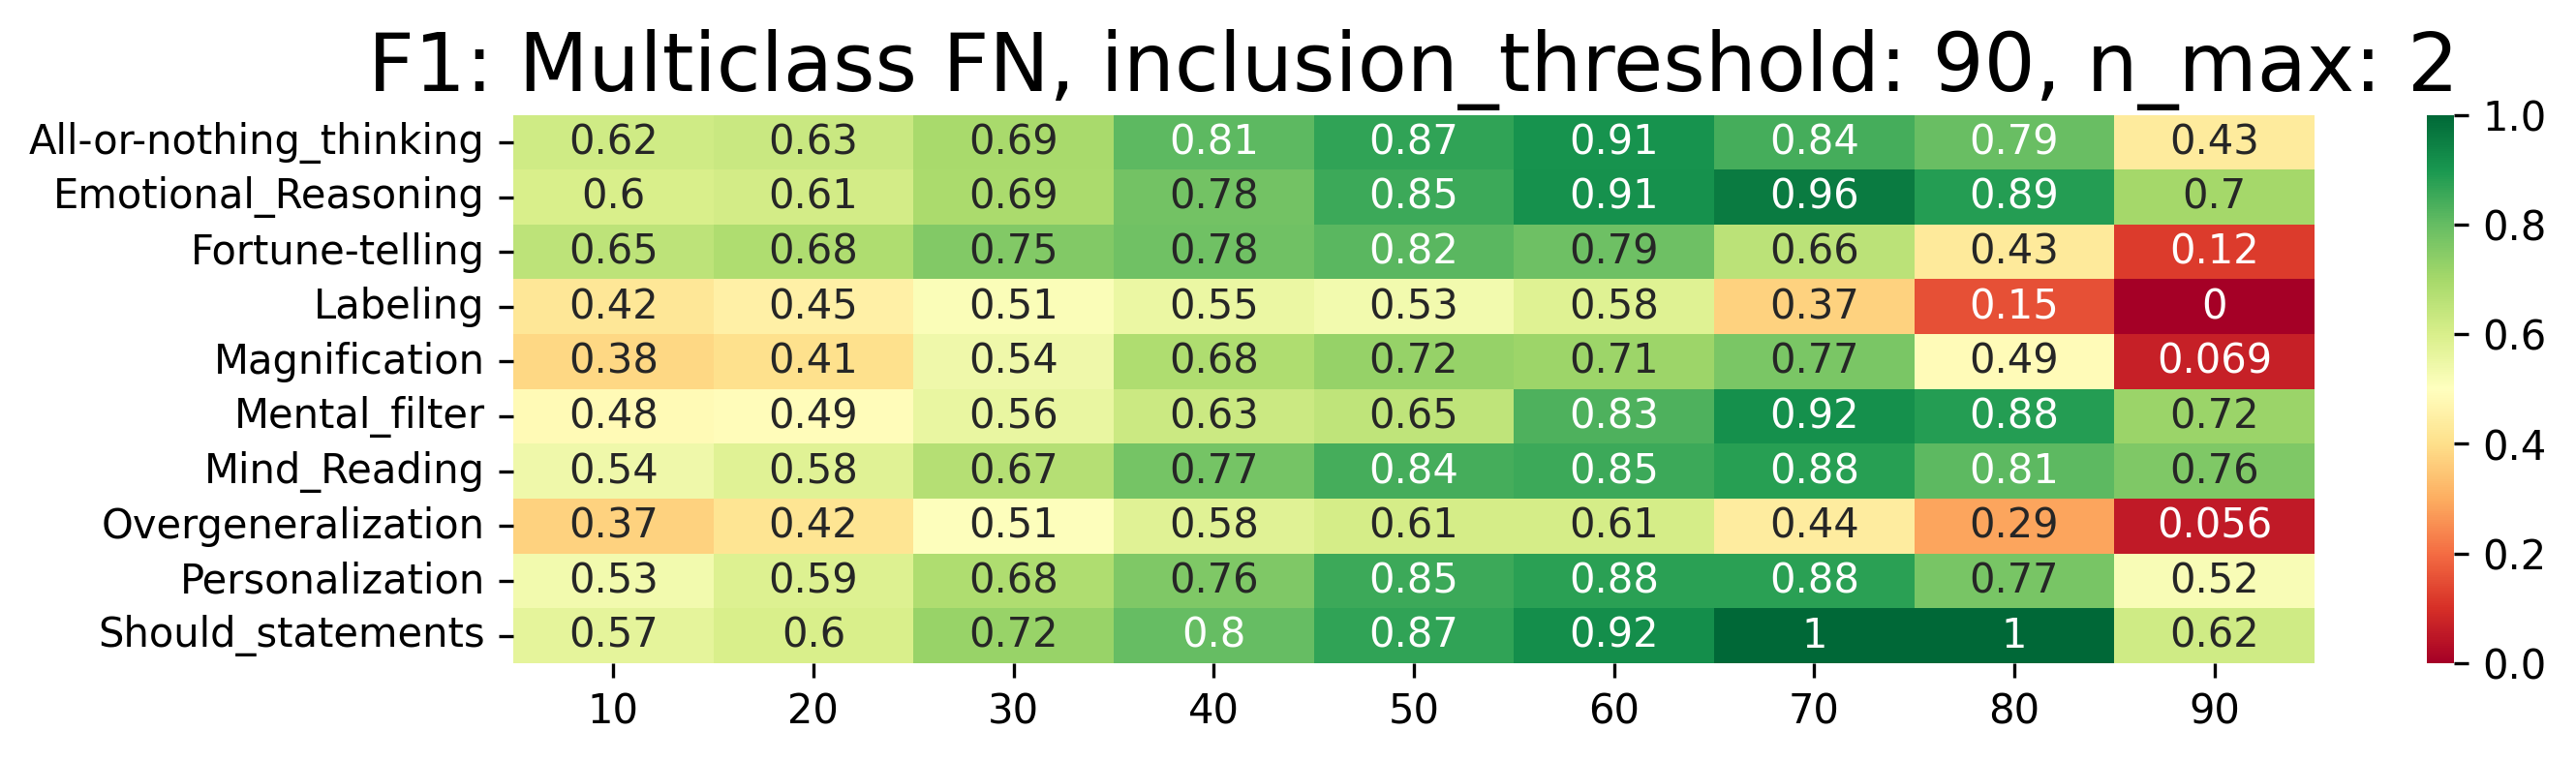

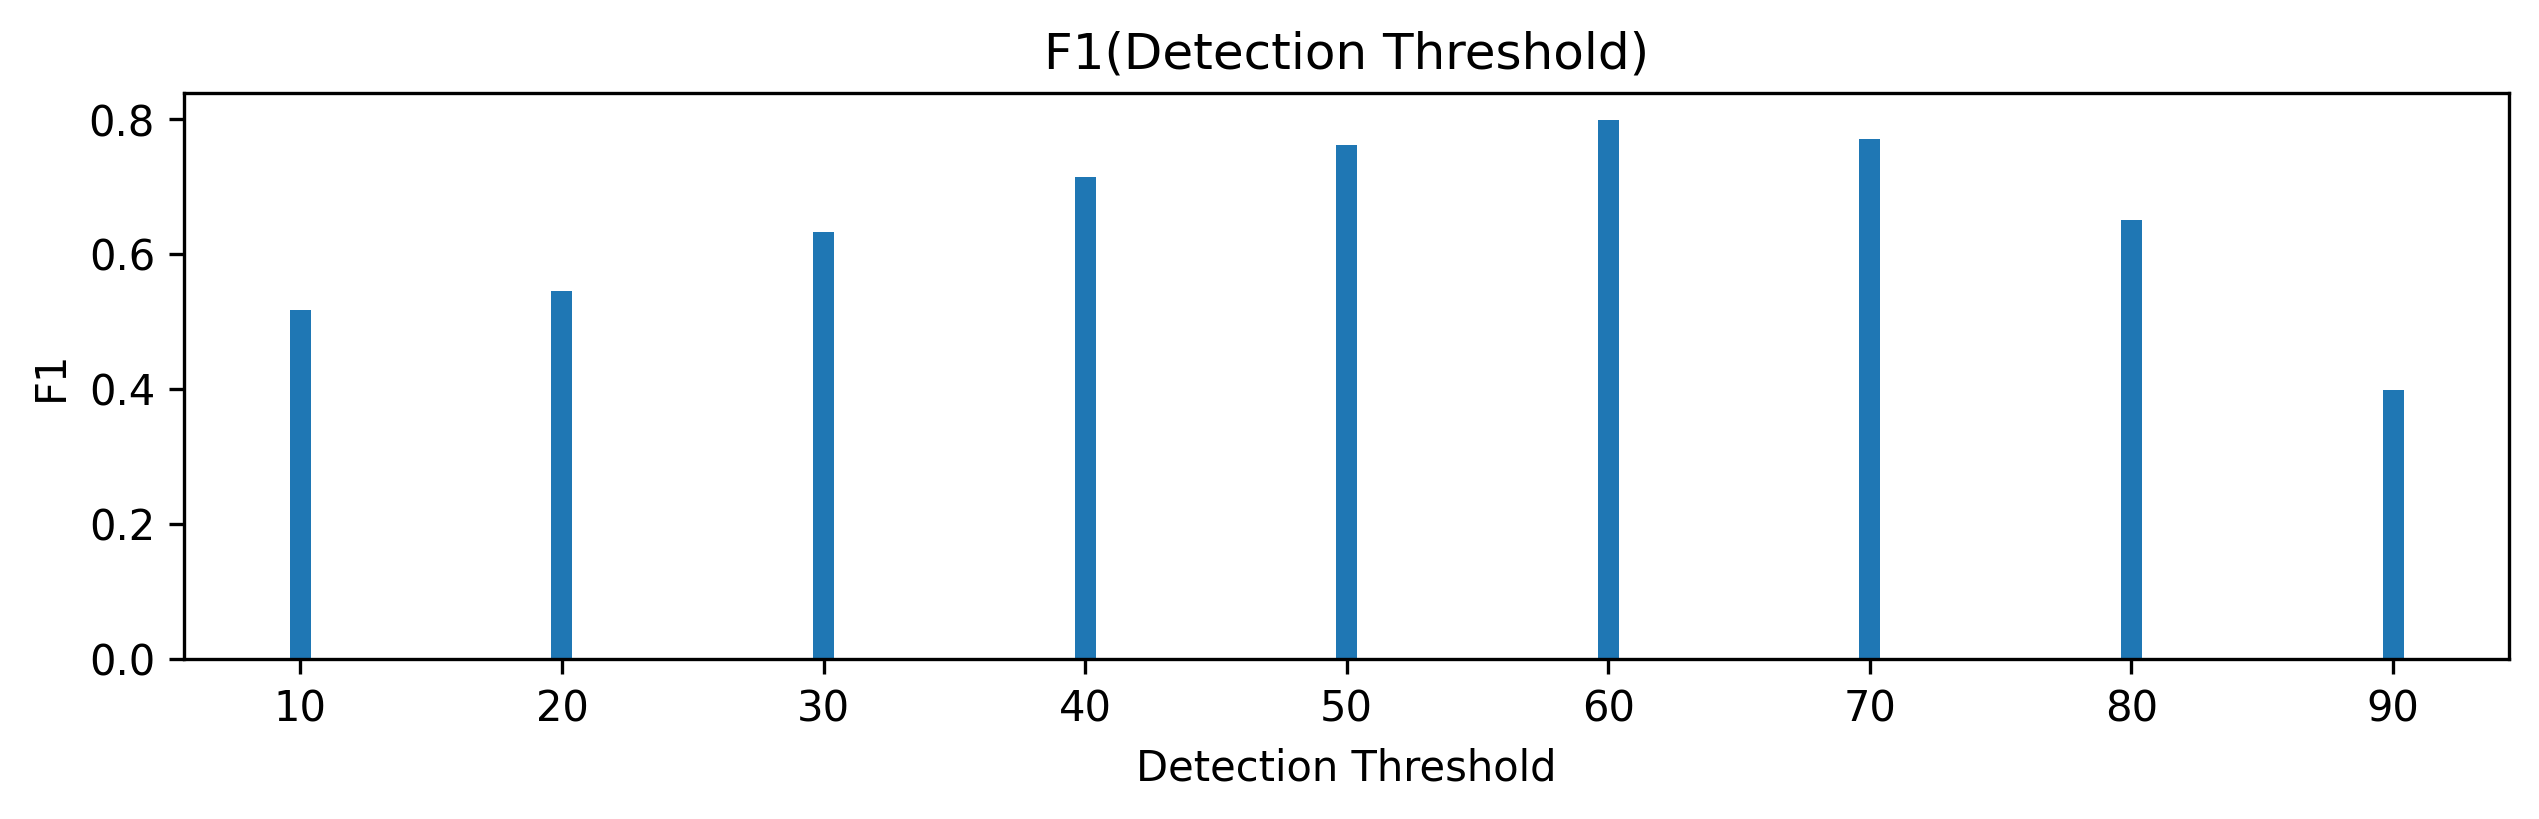

In [6]:
shift = 0
full_test_circle(df,test_babacan_multiclass_path,f'multi-df-babacan-split-5-{shift+1}',
                validation_fraction=5,inclusion_thresholds=[IT],
                detection_thresholds=detection_thresholds,n_max=NM, selection_metrics = ['FN'],
                all_scores=True,averages=True,split_shift=shift,evaluator=our_evaluator_top)

In [15]:
results1 = []
for shift in splits:
    accumulator = []
    for n_max in n_max_values:
        full_test_circle(df,test_babacan_multiclass_path,f'multi-df-babacan-split-5-{shift+1}',
                validation_fraction=5,inclusion_thresholds=inclusion_thresholds,
                detection_thresholds=detection_thresholds,n_max=n_max, selection_metrics = selection_metrics,
                all_scores=False,averages=False,split_shift=shift,evaluator=our_evaluator_top1,accumulator=accumulator)
    results1.append(accumulator)


Shift=0: train=3623, test=907
Labels count: defaultdict(<class 'int'>, {'Mind_Reading': 349, 'Overgeneralization': 353, 'Magnification': 322, 'Labeling': 283, 'Personalization': 283, 'Fortune-telling': 268, 'Emotional_Reasoning': 272, 'Mental_filter': 257, 'Should_statements': 248, 'All-or-nothing_thinking': 236, 'No_Distortion': 752})
Shift=0: train=3623, test=907
Labels count: defaultdict(<class 'int'>, {'Mind_Reading': 349, 'Overgeneralization': 353, 'Magnification': 322, 'Labeling': 283, 'Personalization': 283, 'Fortune-telling': 268, 'Emotional_Reasoning': 272, 'Mental_filter': 257, 'Should_statements': 248, 'All-or-nothing_thinking': 236, 'No_Distortion': 752})
Shift=0: train=3623, test=907
Labels count: defaultdict(<class 'int'>, {'Mind_Reading': 349, 'Overgeneralization': 353, 'Magnification': 322, 'Labeling': 283, 'Personalization': 283, 'Fortune-telling': 268, 'Emotional_Reasoning': 272, 'Mental_filter': 257, 'Should_statements': 248, 'All-or-nothing_thinking': 236, 'No_Disto

In [16]:
summary = []
for l1,l2,l3 in zip(results1[0],results1[1],results1[2]):
    summary.append( l1[0:4] + agg_min_max_avg_mpe((l1[4],l2[4],l3[4])))
summary = sorted(summary, key=lambda x: (-x[6],x[2],x[0],-x[1],x[3])) # sort by -F1avg, SM, NM, -IT, RT
NM, IT, SM, DT = summary[0][:4] 
print(NM, IT, SM, DT)
print()
print([s for s in summary if s[2]=='MR'][:1])
print([s for s in summary if s[2]=='FCR'][:1])
print([s for s in summary if s[2]=='FN'][:1])
print()
for s in summary[:20]:
    print(s)

4 80 MR 40

[(4, 80, 'MR', 40, 0.8871984818076772, 0.9164508106001581, 0.9027830220931646, 1.1508516741452492)]
[(2, 70, 'FCR', 60, 0.8667840370779727, 0.8849712398029915, 0.8743744669660739, 0.80795076840753)]
[(2, 70, 'FN', 60, 0.8667840370779727, 0.8849712398029915, 0.8743744669660739, 0.80795076840753)]

(4, 80, 'MR', 40, 0.8871984818076772, 0.9164508106001581, 0.9027830220931646, 1.1508516741452492)
(5, 80, 'MR', 40, 0.8871984818076772, 0.9164508106001581, 0.9027830220931646, 1.1508516741452492)
(4, 80, 'NLMI', 40, 0.8871984818076772, 0.9164508106001581, 0.9027830220931646, 1.1508516741452492)
(5, 80, 'NLMI', 40, 0.8871984818076772, 0.9164508106001581, 0.9027830220931646, 1.1508516741452492)
(4, 90, 'MR', 40, 0.8852032836559772, 0.9150539852033326, 0.9017342476588895, 1.2221608192458375)
(5, 90, 'MR', 40, 0.8852032836559772, 0.9150539852033326, 0.9017342476588895, 1.2221608192458375)
(4, 90, 'NLMI', 40, 0.8852032836559772, 0.9150539852033326, 0.9017342476588895, 1.2221608192458375

Shift=0: train=3623, test=907
Labels count: defaultdict(<class 'int'>, {'Mind_Reading': 349, 'Overgeneralization': 353, 'Magnification': 322, 'Labeling': 283, 'Personalization': 283, 'Fortune-telling': 268, 'Emotional_Reasoning': 272, 'Mental_filter': 257, 'Should_statements': 248, 'All-or-nothing_thinking': 236, 'No_Distortion': 752})


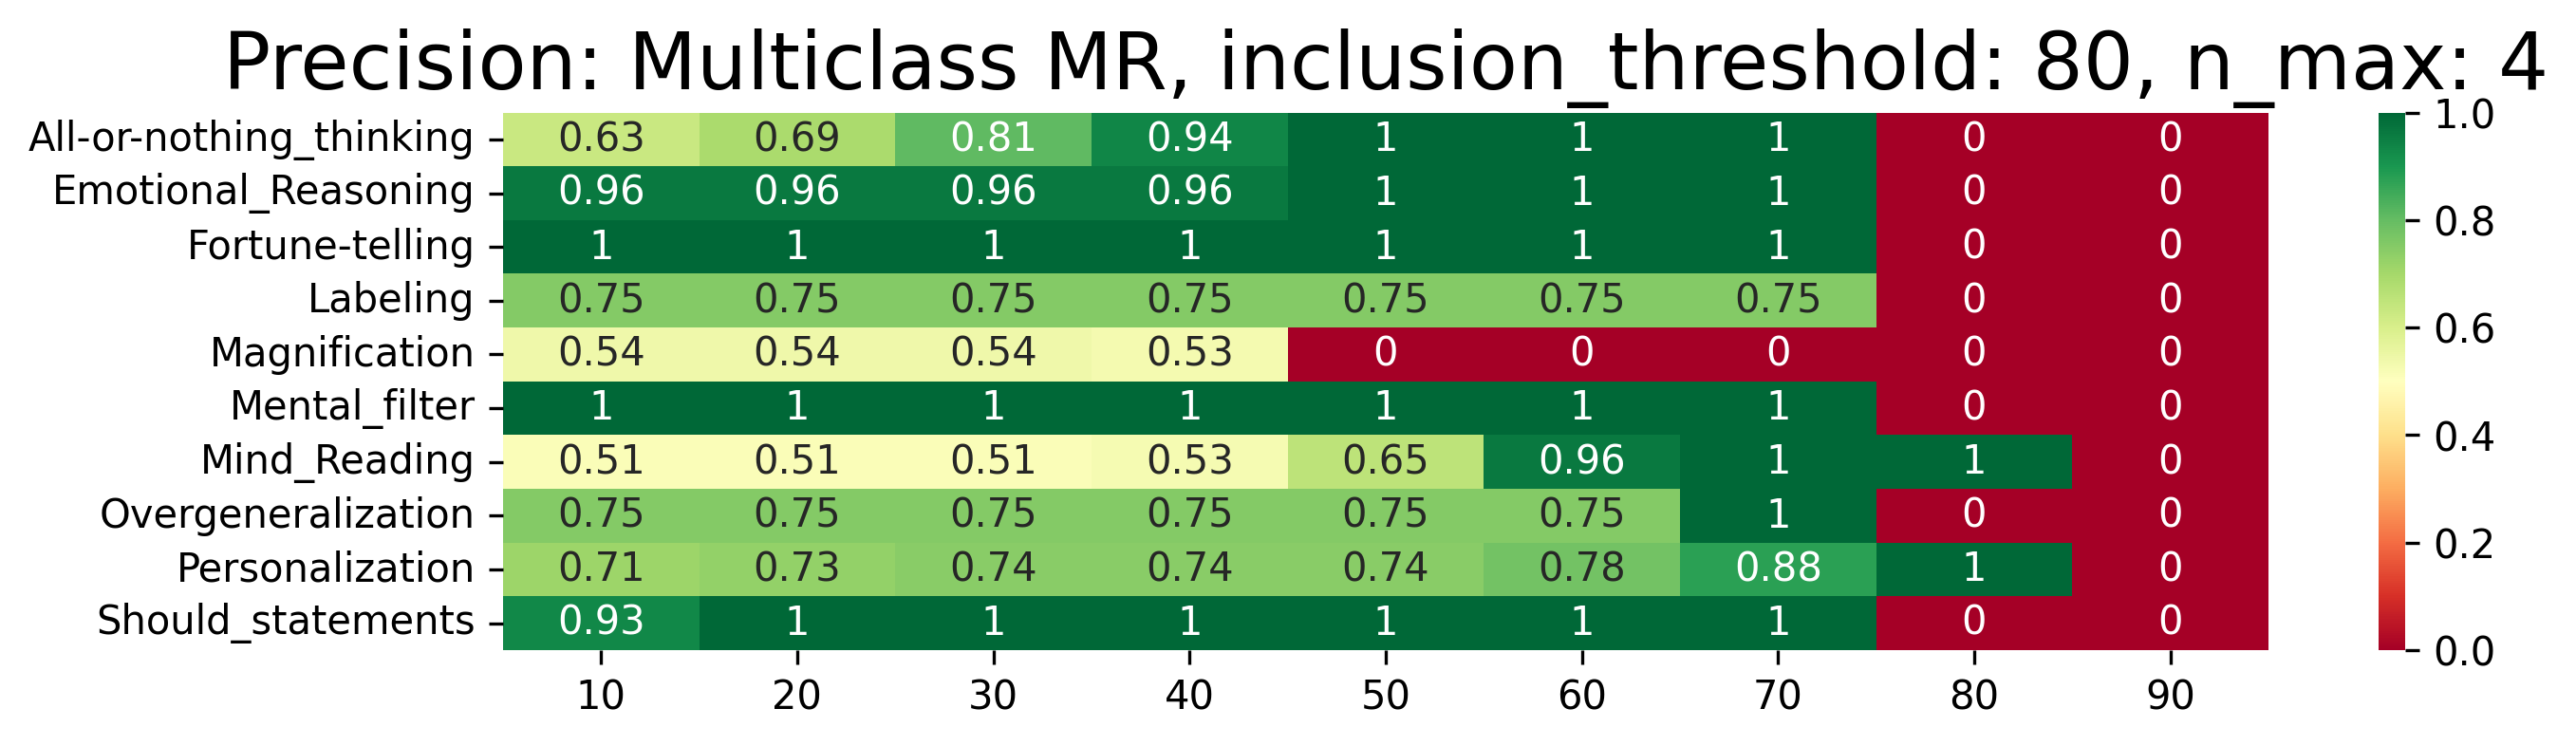

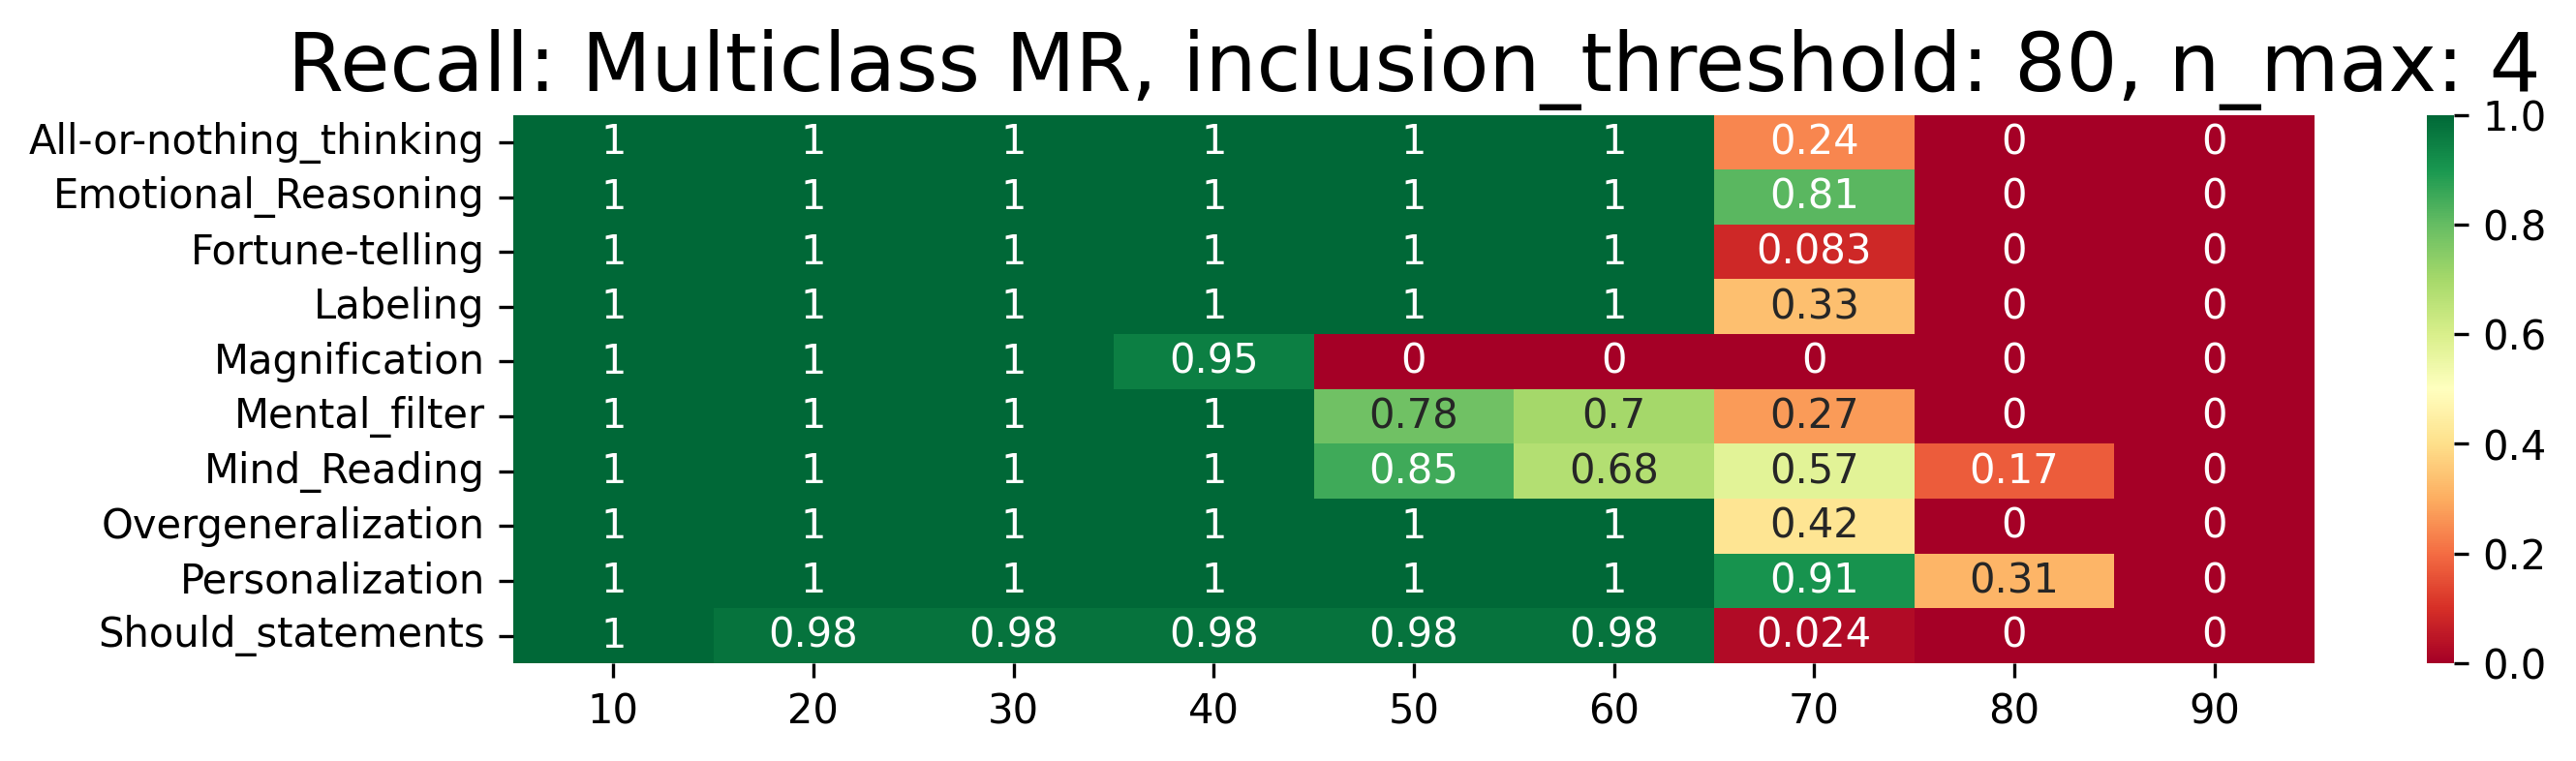

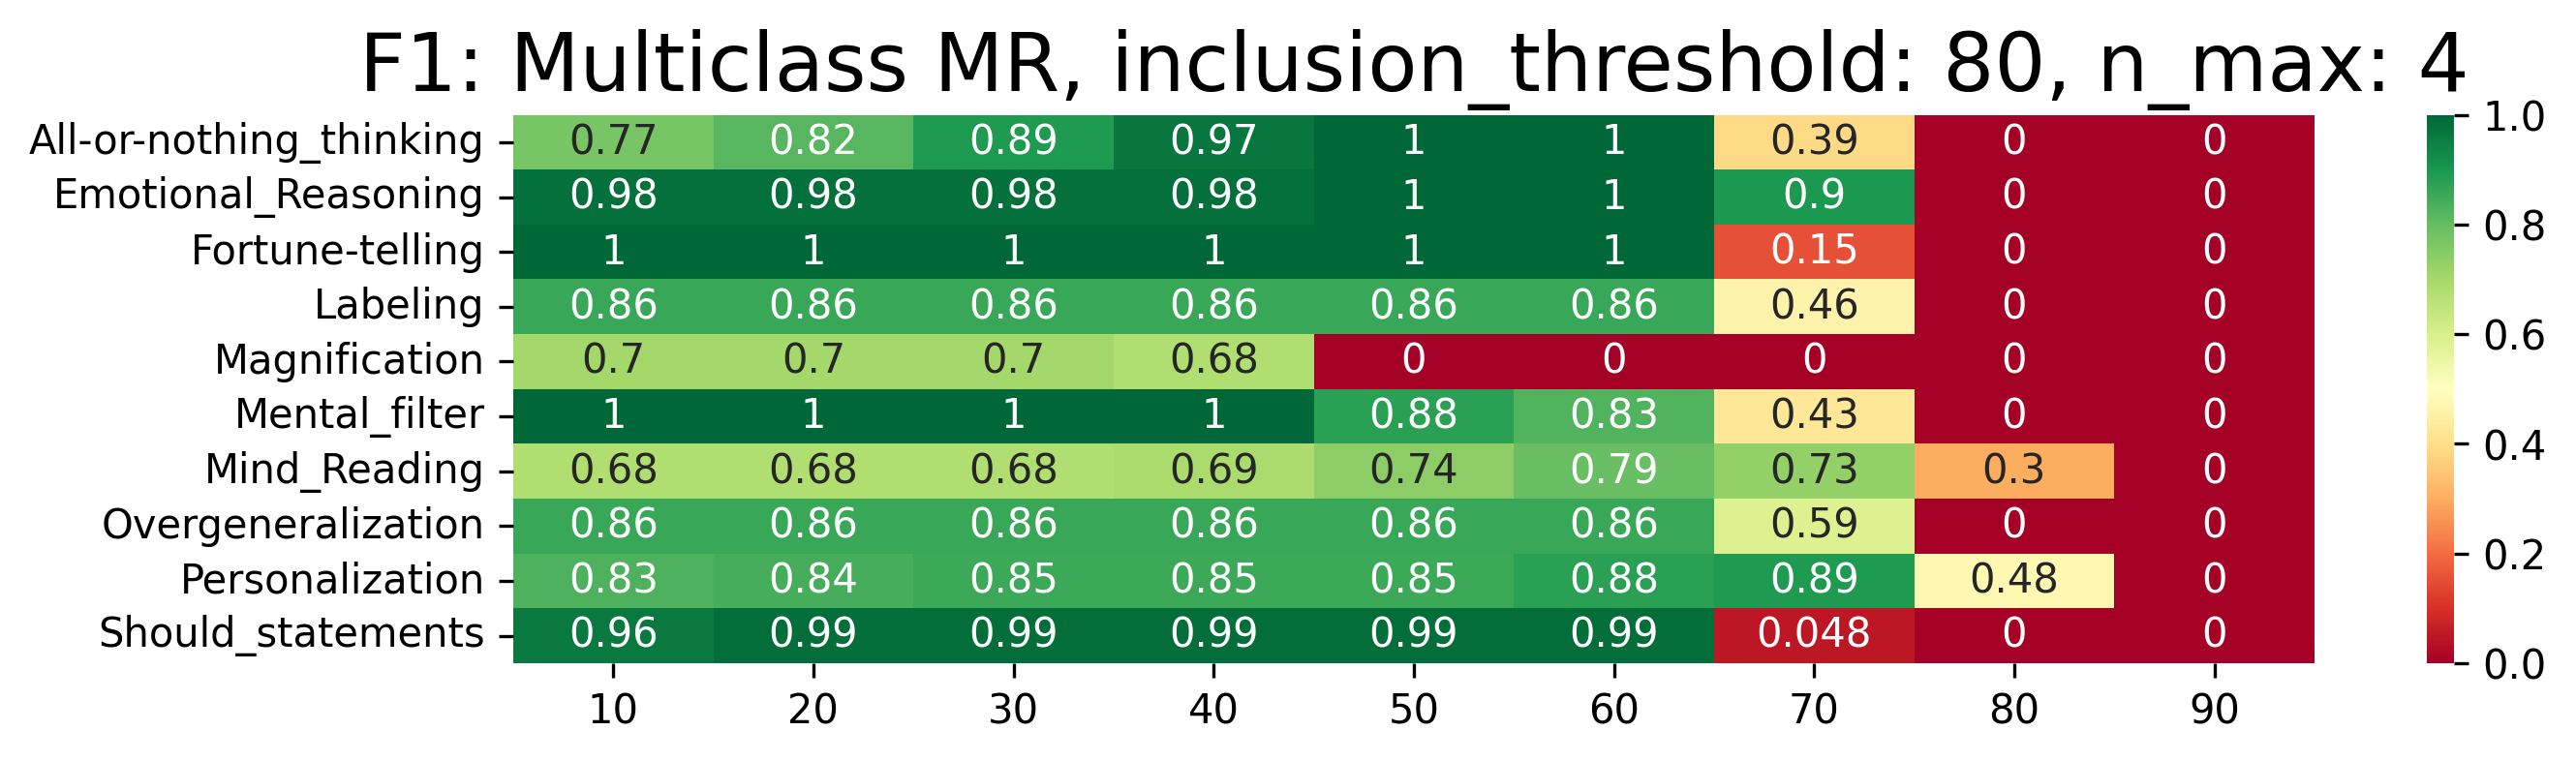

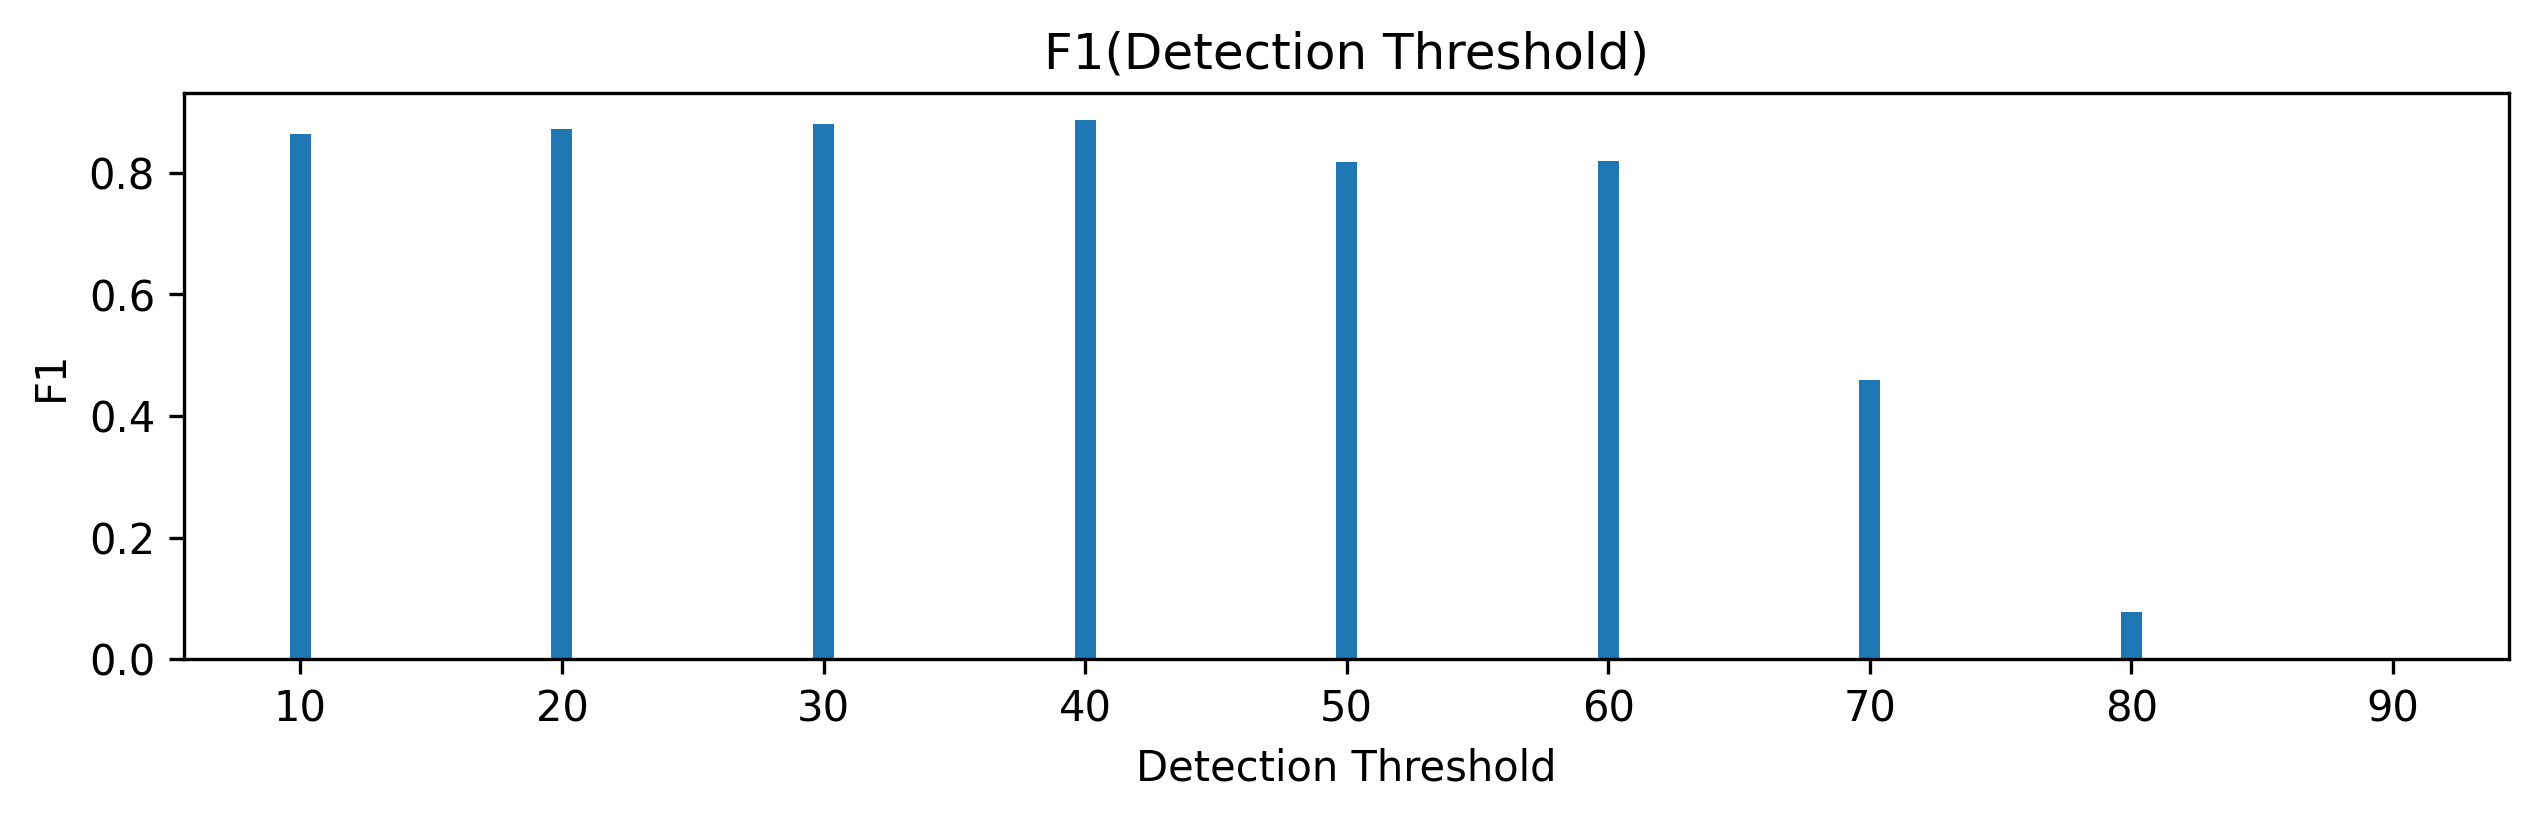

In [17]:
shift = 0
full_test_circle(df,test_babacan_multiclass_path,f'multi-df-babacan-split-5-{shift+1}',
                validation_fraction=5,inclusion_thresholds=[IT],
                detection_thresholds=detection_thresholds,n_max=NM, selection_metrics = [SM],
                all_scores=True,averages=True,split_shift=shift,evaluator=our_evaluator_top1)

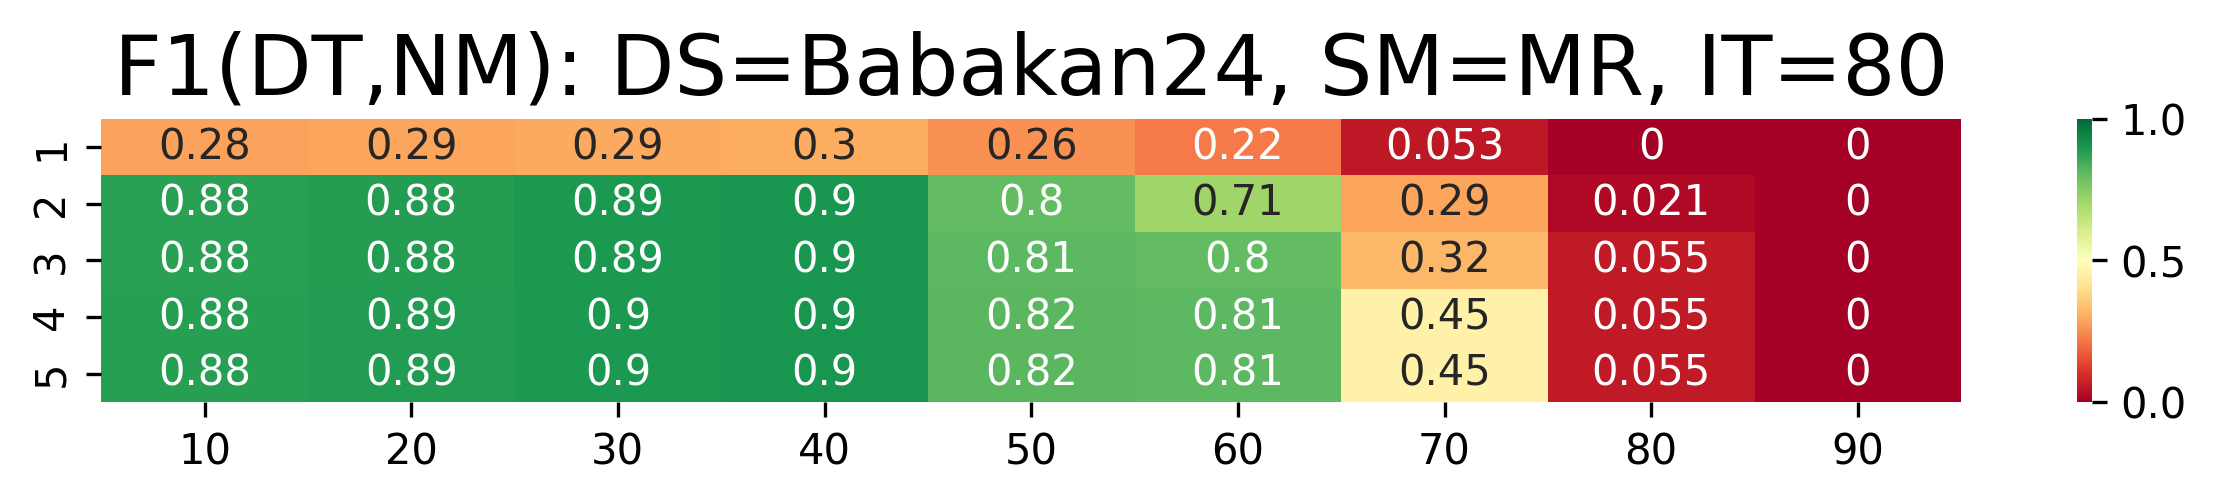

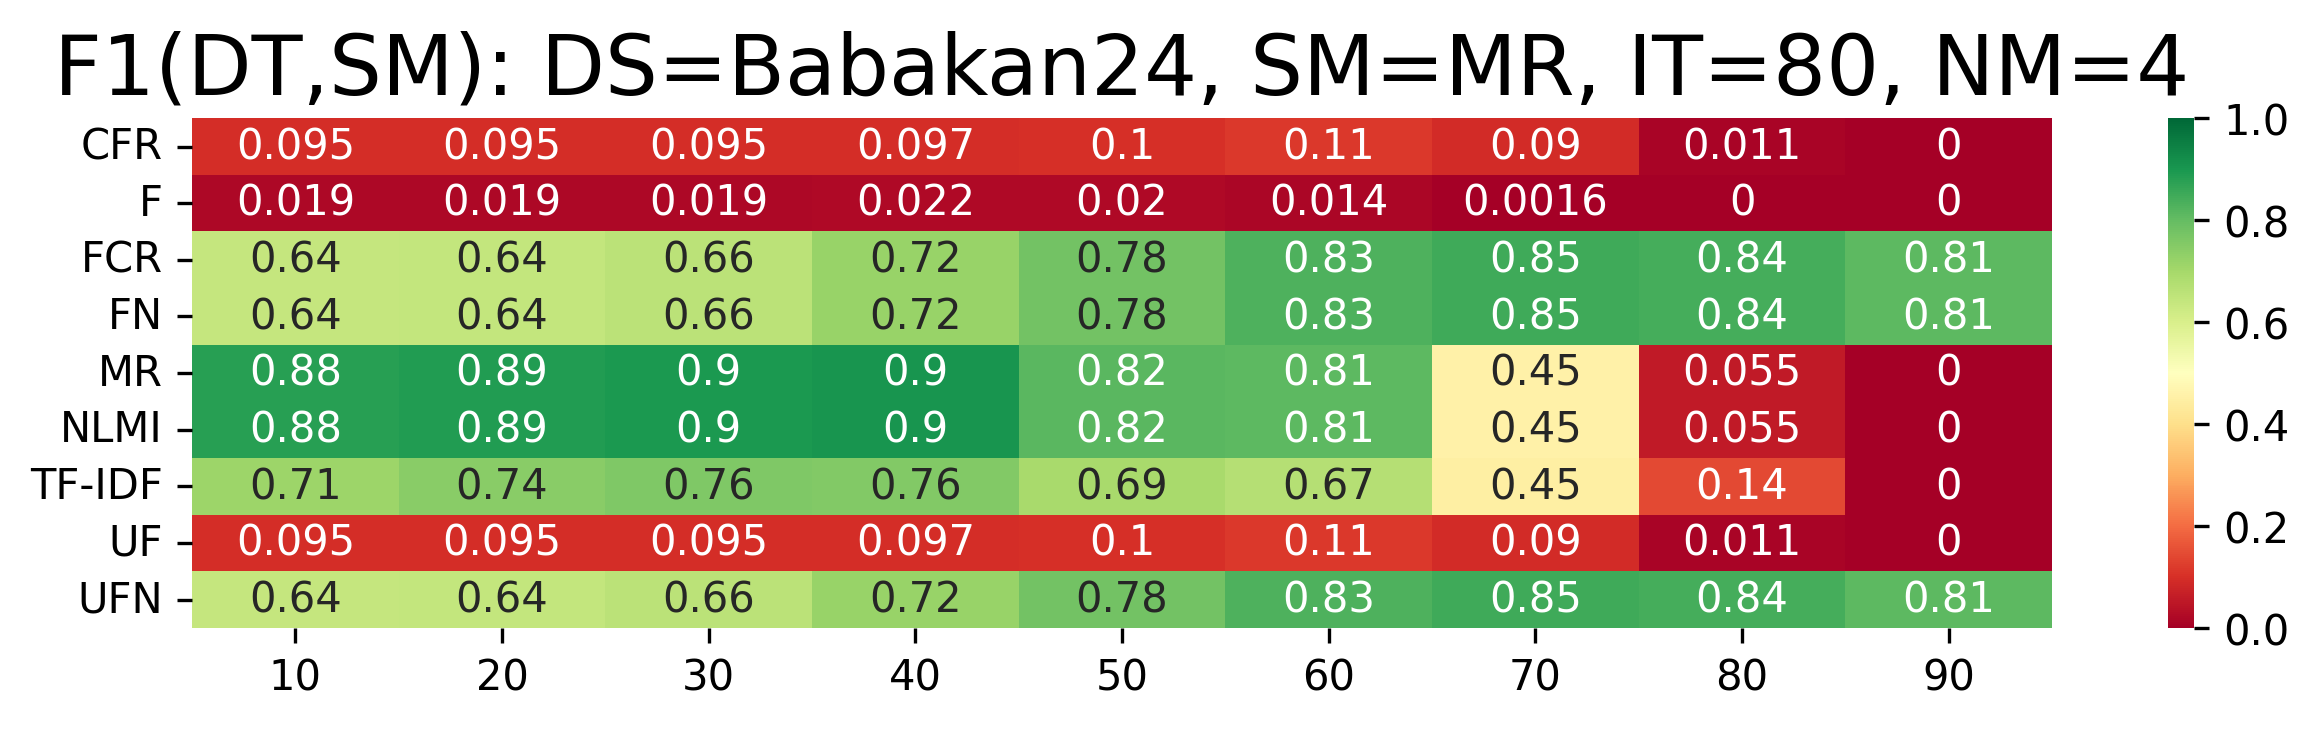

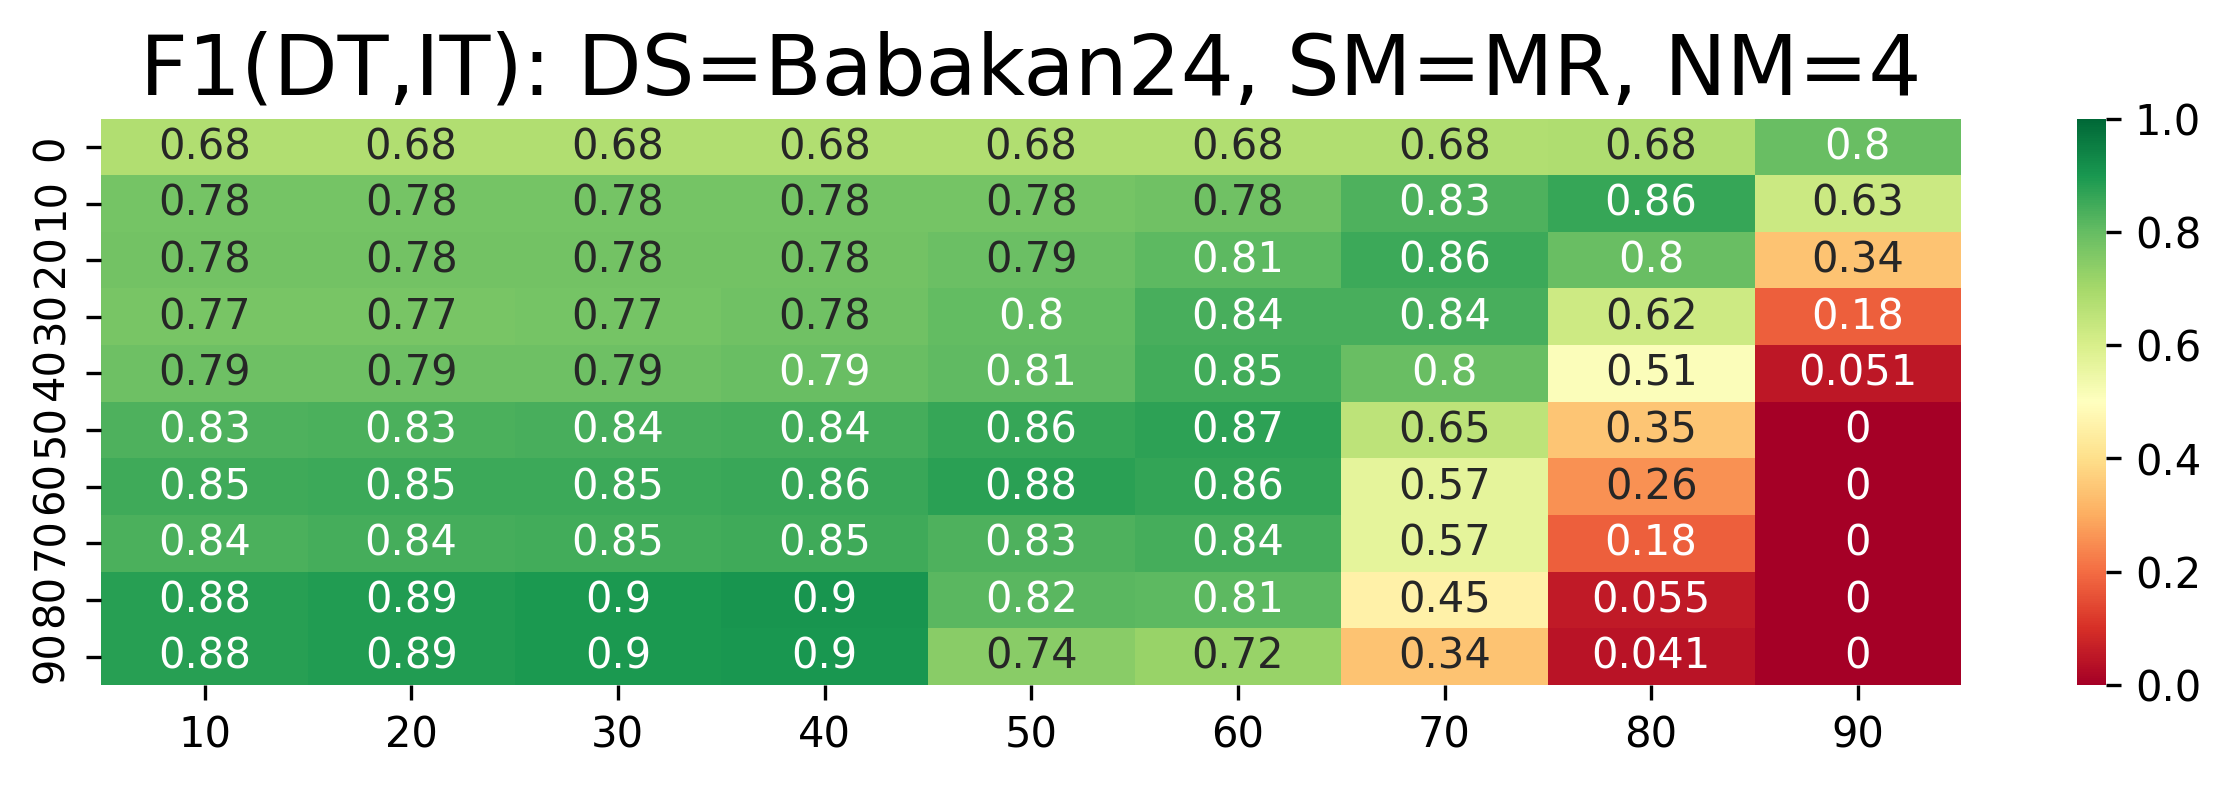

In [18]:
m = build_triple_matrix(summary,0,3,{2:SM,1:IT},6,n_max_values,detection_thresholds)
matrix_plot(n_max_values, detection_thresholds, m, 1.0, title = f'F1(DT,NM): DS={DS}, SM={SM}, IT={IT}', vmin = 0, vmax = 1.0, titlefontsize = 20, dpi = 300, width = 10)

m = build_triple_matrix(summary,2,3,{0:NM,1:IT},6,selection_metrics,detection_thresholds)
matrix_plot(sorted(selection_metrics), detection_thresholds, m, 1.0, title = f'F1(DT,SM): DS={DS}, SM={SM}, IT={IT}, NM={NM}', vmin = 0, vmax = 1.0, titlefontsize = 20, dpi = 300, width = 10)

m = build_triple_matrix(summary,1,3,{0:NM,2:SM},6,inclusion_thresholds, detection_thresholds)
matrix_plot(sorted(inclusion_thresholds), detection_thresholds, m, 1.0, title = f'F1(DT,IT): DS={DS}, SM={SM}, NM={NM}', vmin = 0, vmax = 1.0, titlefontsize = 20, dpi = 300, width = 10)


In [19]:
grand_t1 = dt.datetime.now()
grand_delta = grand_t1 - grand_t0
str(grand_delta)

'11:08:46.667264'